## Watson Assistant chatbot service on IBM Cloud

#### Install/upgrade Watson Python module

In [ ]:
!pip install ibm_watson --upgrade

  Using cached websocket_client-1.1.0-py2.py3-none-any.whl (68 kB)
  Attempting uninstall: websocket-client
    Found existing installation: websocket-client 0.48.0
    Uninstalling websocket-client-0.48.0:
      Successfully uninstalled websocket-client-0.48.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
watson-developer-cloud 2.10.1 requires websocket-client==0.48.0, but you have websocket-client 1.1.0 which is incompatible.


In [ ]:
!pip install watson_developer_cloud

  Using cached websocket_client-0.48.0-py2.py3-none-any.whl (198 kB)
  Attempting uninstall: websocket-client
    Found existing installation: websocket-client 1.1.0
    Uninstalling websocket-client-1.1.0:
      Successfully uninstalled websocket-client-1.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ibm-watson 6.0.0 requires websocket-client==1.1.0, but you have websocket-client 0.48.0 which is incompatible.


In [ ]:
%load_ext autoreload
%autoreload 2

!pip install squarify

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
!pip install cplex
import cplex

In [ ]:
import json
import os
from glob import glob
from bs4 import BeautifulSoup
import IPython
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator
import watson_developer_cloud
from ibm_watson import SpeechToTextV1
from ibm_watson import AssistantV2
from ibm_watson import TextToSpeechV1

import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import math

import getAllLogs
import extractConversations
import intent_heatmap

#### Trial Interact with Watson Assistant chatbot from Python

In [ ]:
assistant = AssistantV2(version='2021-11-27', authenticator=IAMAuthenticator('K2QCaTbt37PDuGJ7iMXaBBmO1JchC3bLEAON_EBHVPLo'))
assistant.set_service_url('https://api.us-east.assistant.watson.cloud.ibm.com/instances/9f9e3fcd-4d57-465a-bbb0-9dbe3f524a84')
ASSISTANT_ID = "160b1ab7-5d17-4fc9-b58e-d559693a2895"
session_id = assistant.create_session(assistant_id=ASSISTANT_ID).get_result()["session_id"]
session_id

'dc072ccd-e8fe-4d56-89ba-f3e05c565200'

In [ ]:
def message_assistant(text):
    response = assistant.message(assistant_id=ASSISTANT_ID,
                                 session_id=session_id,
                                 input={'message_type': 'text', 'text': text}).get_result()
    return BeautifulSoup(response["output"]["generic"][0]["text"]).get_text()

In [ ]:
question_1 = message_assistant("What can you do for me")
question_1

'Hello. I am your Robo Advisor. I can suggest you investment strategies based on your preferences. Would you like to continue?'

In [ ]:
question_2 = message_assistant("yes")
question_2

'What is your total amount of investment?  (Please enter numeric value answers only, e.g. 1000 for 1000 cad)'

In [ ]:
question_3 = message_assistant("1000000")
question_3

'How much cash would you like to keep (at least) in your portfolio? (Please enter percentage answers only, e.g. 20%) '

In [ ]:
question_4 = message_assistant("30%")
question_4

'Which of fellowing sectors are you interested in? Information Technology, Health Care, Financials, Consumer Discretionary, Communication Services, Industrials, Consumer Staples, Energy, Utilities, Real Estate, Materials (Please separate each sector with comma and a space, e.g. Energy, Utilities)'

In [ ]:
question_5 = message_assistant("Information Technology, Health Care, Financials, Consumer Discretionary, Communication Services")
question_5

'Do you consider yourself risk-averse or risk-neutral?'

In [ ]:
question_6 = message_assistant("risk-neutral")
question_6

"Do you wish to take leverage(x2)?  'Yes' enter 1, 'No' enter 2."

In [ ]:
question_7 = message_assistant("2")
question_7

'Okay! You are all set! '

## Extract Client's Response ##

# New Section

Method of extracting uses' inputs were from:<br>
Freed, A. (2020). Analyzing and Improving a Watson Assistant Solution Part 3: Recipes for common analytic patterns. *IBM Data Science in Practice*. https://medium.com/ibm-data-ai/analyzing-and-improving-a-watson-assistant-solution-part-3-recipes-for-common-analytic-patterns-1edb4b1f2ef2 <br>
Code<br>
Freed, A. (2020). log_analytics. GitHub. https://github.com/cognitive-catalyst/WA-Testing-Tool/tree/master/log_analytics.<br>
Changes were made to make functions and codes be compatible with AssistantV2.

In [ ]:
!curl -O https://raw.githubusercontent.com/IzzyFi/1622-final-project-modified-py-functions/extractConversations.py
!curl -O https://raw.githubusercontent.com/IzzyFi/1622-final-project-modified-py-functions/getAllLogs.py
!curl -O https://raw.githubusercontent.com/IzzyFi/1622-final-project-modified-py-functions/intent_heatmap.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    20  100    20    0     0    312      0 --:--:-- --:--:-- --:--:--   312
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    20  100    20    0     0    333      0 --:--:-- --:--:-- --:--:--   333
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    20  100    20    0     0    322      0 --:--:-- --:--:-- --:--:--   322


In [ ]:
# Extract logs from the assistant.
iam_apikey='K2QCaTbt37PDuGJ7iMXaBBmO1JchC3bLEAON_EBHVPLo'
url='https://api.us-east.assistant.watson.cloud.ibm.com/instances/9f9e3fcd-4d57-465a-bbb0-9dbe3f524a84'
workspace_id="160b1ab7-5d17-4fc9-b58e-d559693a2895"
#time filter
log_filter="response_timestamp>=2022-04-16 ,response_timestamp<2022-04-20"
#Change the number of logs retrieved, default settings will return 10,000 logs (20 pages of 500)
page_size_limit=500
page_num_limit=20
#WA API version
version="2021-11-27"
#raw log data
rawLogsJson = getAllLogs.getLogs(iam_apikey, url, workspace_id, log_filter, page_size_limit, page_num_limit, version)

[autoreload of getAllLogs failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
  File "/content/getAllLogs.py", line 1
    400: Invalid request
                       ^
SyntaxError: invalid syntax
]
[autoreload of extractConversations failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
  File "/content/extractConversations.py", line 1
    400: Invalid request
                       ^
SyntaxError: invalid syntax
]
[autoreload of intent_heatmap failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
  File "/content/intent_heatmap.py", line 1
    400: Invalid request
                      

Fetched 1 log pages with 212 total logs


In [ ]:
# Define the conversation corrrelation field name for the Watson Assistant records.
primaryLogKey = "response.context.conversation_id"

#Note conversation id is the session id defined above
conversationKey='conversation_id'
customFieldNames = None
#extract conversation as DataFrame
allLogsDF = extractConversations.extractConversationData(rawLogsJson, primaryLogKey, customFieldNames)
conversationsGroup = allLogsDF.groupby(conversationKey,as_index=False)

In [ ]:
allLogsDF=allLogsDF.sort_values(by=['request_timestamp', 'dialog_turn_counter']) #sorted by time

In [ ]:
allLogsDF=allLogsDF.reset_index(drop=True)
allLogsDF

,conversation_id,dialog_turn_counter,request_timestamp,response_timestamp,input.text,output.text,nodes_visited,prev_nodes_visited,conversation_start,message_start,message_end,dialog_turn_number,conversation_length,is_final_turn
0,547742d9-654c-45b0-a4a2-1f116de4433a,1,2022-04-16 00:26:39.796000+00:00,2022-04-16 00:26:39.944000+00:00,What can you do for me,Hello. I am your Robo Advisor. I can suggest y...,"(Welcome,)",,2022-04-16 00:26:39.796000+00:00,0 days 00:00:00,0 days 00:00:00,1,7,False
1,547742d9-654c-45b0-a4a2-1f116de4433a,2,2022-04-16 00:26:40.560000+00:00,2022-04-16 00:26:40.632000+00:00,yes,What is your total amount of investment? (Ple...,"(node_9_1649990712988,)","(Welcome,)",2022-04-16 00:26:39.796000+00:00,0 days 00:00:00.148000,0 days 00:00:00.764000,2,7,False
2,547742d9-654c-45b0-a4a2-1f116de4433a,3,2022-04-16 00:26:41.542000+00:00,2022-04-16 00:26:41.658000+00:00,1600,1600 thank you. How much cash would you like ...,"(node_9_1649991209487,)","(node_9_1649990712988,)",2022-04-16 00:26:39.796000+00:00,0 days 00:00:00.836000,0 days 00:00:01.746000,3,7,False
3,547742d9-654c-45b0-a4a2-1f116de4433a,4,2022-04-16 00:26:42.583000+00:00,2022-04-16 00:26:42.693000+00:00,70%,70% thank you. Which of fellowing sectors are...,"(node_9_1649991523458,)","(node_9_1649991209487,)",2022-04-16 00:26:39.796000+00:00,0 days 00:00:01.862000,0 days 00:00:02.787000,4,7,False
4,547742d9-654c-45b0-a4a2-1f116de4433a,5,2022-04-16 00:26:43.341000+00:00,2022-04-16 00:26:43.461000+00:00,"Information Technology, Health Care","Information Technology, Health Care thank you...","(node_1_1649991678098,)","(node_9_1649991523458,)",2022-04-16 00:26:39.796000+00:00,0 days 00:00:02.897000,0 days 00:00:03.545000,5,7,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,dc072ccd-e8fe-4d56-89ba-f3e05c565200,3,2022-04-17 03:55:58.708000+00:00,2022-04-17 03:55:58.771000+00:00,1000000,How much cash would you like to keep (at least...,"(node_9_1649991209487,)","(node_9_1649990712988,)",2022-04-17 03:55:56.521000+00:00,0 days 00:00:01.290000,0 days 00:00:02.187000,3,7,False
208,dc072ccd-e8fe-4d56-89ba-f3e05c565200,4,2022-04-17 03:55:59.828000+00:00,2022-04-17 03:55:59.911000+00:00,30%,Which of fellowing sectors are you interested ...,"(node_9_1649991523458,)","(node_9_1649991209487,)",2022-04-17 03:55:56.521000+00:00,0 days 00:00:02.250000,0 days 00:00:03.307000,4,7,False
209,dc072ccd-e8fe-4d56-89ba-f3e05c565200,5,2022-04-17 03:56:00.934000+00:00,2022-04-17 03:56:01.042000+00:00,"Information Technology, Health Care, Financial...",Do you consider yourself risk-averse or risk-n...,"(node_1_1649991678098,)","(node_9_1649991523458,)",2022-04-17 03:55:56.521000+00:00,0 days 00:00:03.390000,0 days 00:00:04.413000,5,7,False
210,dc072ccd-e8fe-4d56-89ba-f3e05c565200,6,2022-04-17 03:56:02.065000+00:00,2022-04-17 03:56:02.159000+00:00,risk-neutral,Do you wish to take leverage(x2)? 'Yes' enter...,"(node_3_1649991980851,)","(node_1_1649991678098,)",2022-04-17 03:55:56.521000+00:00,0 days 00:00:04.521000,0 days 00:00:05.544000,6,7,False


In [ ]:
allLogsDF.dtypes

conversation_id                     object
dialog_turn_counter                  int64
request_timestamp      datetime64[ns, UTC]
response_timestamp     datetime64[ns, UTC]
input.text                          object
output.text                         object
nodes_visited                       object
prev_nodes_visited                  object
conversation_start     datetime64[ns, UTC]
message_start              timedelta64[ns]
message_end                timedelta64[ns]
dialog_turn_number                   int64
conversation_length                  int64
is_final_turn                         bool
dtype: object

In [ ]:
latest = allLogsDF.loc[(allLogsDF['conversation_id']==session_id)] #find the log of latest session
latest

,conversation_id,dialog_turn_counter,request_timestamp,response_timestamp,input.text,output.text,nodes_visited,prev_nodes_visited,conversation_start,message_start,message_end,dialog_turn_number,conversation_length,is_final_turn
205,dc072ccd-e8fe-4d56-89ba-f3e05c565200,1,2022-04-17 03:55:56.521000+00:00,2022-04-17 03:55:56.604000+00:00,What can you do for me,Hello. I am your Robo Advisor. I can suggest y...,"(Welcome,)",,2022-04-17 03:55:56.521000+00:00,0 days 00:00:00,0 days 00:00:00,1,7,False
206,dc072ccd-e8fe-4d56-89ba-f3e05c565200,2,2022-04-17 03:55:57.732000+00:00,2022-04-17 03:55:57.811000+00:00,yes,What is your total amount of investment? (Ple...,"(node_9_1649990712988,)","(Welcome,)",2022-04-17 03:55:56.521000+00:00,0 days 00:00:00.083000,0 days 00:00:01.211000,2,7,False
207,dc072ccd-e8fe-4d56-89ba-f3e05c565200,3,2022-04-17 03:55:58.708000+00:00,2022-04-17 03:55:58.771000+00:00,1000000,How much cash would you like to keep (at least...,"(node_9_1649991209487,)","(node_9_1649990712988,)",2022-04-17 03:55:56.521000+00:00,0 days 00:00:01.290000,0 days 00:00:02.187000,3,7,False
208,dc072ccd-e8fe-4d56-89ba-f3e05c565200,4,2022-04-17 03:55:59.828000+00:00,2022-04-17 03:55:59.911000+00:00,30%,Which of fellowing sectors are you interested ...,"(node_9_1649991523458,)","(node_9_1649991209487,)",2022-04-17 03:55:56.521000+00:00,0 days 00:00:02.250000,0 days 00:00:03.307000,4,7,False
209,dc072ccd-e8fe-4d56-89ba-f3e05c565200,5,2022-04-17 03:56:00.934000+00:00,2022-04-17 03:56:01.042000+00:00,"Information Technology, Health Care, Financial...",Do you consider yourself risk-averse or risk-n...,"(node_1_1649991678098,)","(node_9_1649991523458,)",2022-04-17 03:55:56.521000+00:00,0 days 00:00:03.390000,0 days 00:00:04.413000,5,7,False
210,dc072ccd-e8fe-4d56-89ba-f3e05c565200,6,2022-04-17 03:56:02.065000+00:00,2022-04-17 03:56:02.159000+00:00,risk-neutral,Do you wish to take leverage(x2)? 'Yes' enter...,"(node_3_1649991980851,)","(node_1_1649991678098,)",2022-04-17 03:55:56.521000+00:00,0 days 00:00:04.521000,0 days 00:00:05.544000,6,7,False
211,dc072ccd-e8fe-4d56-89ba-f3e05c565200,7,2022-04-17 03:56:03.026000+00:00,2022-04-17 03:56:03.101000+00:00,2,Okay! You are all set!,"(node_5_1649992075203,)","(node_3_1649991980851,)",2022-04-17 03:55:56.521000+00:00,0 days 00:00:05.638000,0 days 00:00:06.505000,7,7,True


In [ ]:
# Find investment amount
invest_total = int(latest.loc[(latest['dialog_turn_counter']==3)]['input.text'].values[0])

# Risk preference:  0 = Risk averse, 1 = Risk neutral
if latest.loc[(latest['dialog_turn_counter']==6)]['input.text'].values[0]=='risk-averse':
  risk_opt = 0
else:
  risk_opt = 1

# ETFs: A list of ETFs
industry = latest.loc[(latest['dialog_turn_counter']==5)]['input.text'].values[0]
industry_list=industry.split(", ")
etf_dict = {'Communication Services':'XLC', 'Materials': 'XLB', 'Energy':'XLE', 'Financials':'XLF', 'Industrials':'XLI', 'Information Technology':'XLK', 'Consumer Staples':'XLP', 'Utilities':'XLU', 'Health Care':'XLV', 'Consumer Discretionary':'XLY', 'Real Estate':'XLRE'}
preferred_etf = []
for key in industry_list:
  preferred_etf.append(etf_dict.get(key))
print('The chosen ETFs are:',preferred_etf)

# Cash percentage
cash_pct = float(latest.loc[(latest['dialog_turn_counter']==4)]['input.text'].values[0][:-1])/100

# Risk decision: If risk averse, min-risk or equally-risk: 0=min-risk, 1=equal risk
# Leverage if risk neutral: 0=no leverage, 1=leverage
if latest.loc[(latest['dialog_turn_counter']==7)]['input.text'].values[0]=='minimizing risk':
  min_var_opt = 0
  print("The risk decision is",min_var_opt)
elif latest.loc[(latest['dialog_turn_counter']==7)]['input.text'].values[0]=='equally-distributed risk':
  min_var_opt = 1
  print("The risk decision is",min_var_opt)
elif latest.loc[(latest['dialog_turn_counter']==7)]['input.text'].values[0]=='1':
  leverage_opt = 1
  print("The leverage choice is",leverage_opt)
else:
  leverage_opt = 0
  print("The leverage choice is",leverage_opt)

print("The total amount of investment is %s, the cash percentage is %s, and the risk preference is %d."%(invest_total,cash_pct,risk_opt))

The chosen ETFs are: ['XLK', 'XLV', 'XLF', 'XLY', 'XLC']
The leverage choice is 0
The total amount of investment is 1000000, the cash percentage is 0.3, and the risk preference is 1.


## Optimization Program ##

In [ ]:
# Reading csv data
df = pd.read_csv('ap.csv')

In [ ]:
# # date helper
# def convert_date_to_array(datestr):
#     temp = [int(x) for x in datestr.split('/')]
#     return [temp[-1], temp[0], temp[1]]

In [ ]:
# # Only preferred ETFs are included
# dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
# data_prices = df[preferred_etf].to_numpy()
# dates = np.array(df['Date'])

In [ ]:
# day_ind_start0 = 0
# day_ind_end0 = len(np.where(dates_array[:,0]==2018)[0])
# cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
# mu = np.mean(cur_returns0, axis = 0)
# Q = np.cov(cur_returns0.T)

In [ ]:
# day_2022_start = np.where(dates_array[:,0]==2022)[0][0]
# day_2022_end = np.where(dates_array[:,0]==2022)[0][-1]
# returns_2022 = data_prices[day_2022_start+1:day_2022_end,:] / data_prices[day_2022_start:day_2022_end-1,:] - 1
# mu_2022 = np.mean(returns_2022, axis = 0)
# Q_2022 = np.cov(returns_2022.T)
# data_prices_2022 = data_prices[day_2022_start:,:]


In [ ]:
# # store 2022 data price
# data_prices_2022 = data_prices[day_2022_start:,:]
# dates_array_2022 = dates_array[day_2022_start:,:]
# dates_2022 = dates[day_2022_start:]

# # Remove datapoints for year 2018 and 2022
# data_prices = data_prices[day_ind_end0:day_2022_start,:]
# dates_array = dates_array[day_ind_end0:day_2022_start,:]
# dates = dates[day_ind_end0:day_2022_start]

In [ ]:
# # Initialize weights according to selected ETF.
# init_position = np.zeros((1,len(preferred_etf)))
# init_value = invest_total
# w_init = np.zeros((1,len(preferred_etf)))

# # Number of periods, assets, trading days
# N_periods = 4*len(np.unique(dates_array[:,0]))-3 # 4 periods per year
# N = len(df.columns)-1
# N_days = len(dates)

# # Annual risk-free rates approximated by average 10-years treasury bonds rate
# r_rf_2019 = 0.0214
# r_rf_2020 = 0.0089
# r_rf_2021 = 0.0145
# r_rf_2022 = 0.0204


# strategy_names = ['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio',
#                   'Maximum Sharpe Ratio Portfolio', 'Equal Risk Contributions Portfolio',
#                   'Leveraged Equal Risk Contributions Portfolio', 'Robust Optimization Portfolio']


In [ ]:
!apt install coinor-libipopt-dev
!pip install ipopt

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  coinor-libipopt1v5 libmumps-5.1.2 libmumps-dev libmumps-seq-5.1.2
  libmumps-seq-dev libscalapack-mpi-dev libscalapack-openmpi-dev
  libscalapack-openmpi2.0 libscotch-6.0
Suggested packages:
  scalapack-doc
The following NEW packages will be installed:
  coinor-libipopt-dev coinor-libipopt1v5 libmumps-5.1.2 libmumps-dev
  libmumps-seq-5.1.2 libmumps-seq-dev libscalapack-mpi-dev
  libscalapack-openmpi-dev libscalapack-openmpi2.0 libscotch-6.0
0 upgraded, 10 newly installed, 0 to remove and 39 not upgraded.
Need to get 7,515 kB of archives.
After this operation, 50.3 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libscalapack-openmpi2.0 amd64 2.0.2-4 [1,473 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libmumps-5.1.2 amd64 5.1.2-4 [1,103 kB]
Get:3 http://archive.ubu

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import math

import cplex
import cyipopt as ipopt

In [ ]:
# functions

def strat_buy_and_hold(x_init, cash_init, mu, Q, cur_prices):
   x_optimal = x_init
   cash_optimal = cash_init
   return x_optimal, cash_optimal

def strat_equally_weighted(x_init, cash_init, mu, Q, cur_prices, cash_pct, period):
   if period == 1:
      x_new = (1-cash_pct)*invest_total/(len(preferred_etf)*cur_prices)
      x_optimal = np.array([math.floor(number) for number in x_new])
      net_prof = (x_init - x_optimal)@cur_prices - 0.005*(np.abs((x_init-x_optimal))@cur_prices)
      cash_optimal = invest_total + net_prof - 0.005*(np.abs((x_init-x_optimal))@cur_prices)
   else:
      x_new = (x_init@cur_prices/(len(preferred_etf)*cur_prices))
      x_optimal = np.array([math.floor(number) for number in x_new])
      net_prof = (x_init - x_optimal)@cur_prices - 0.005*(np.abs((x_init-x_optimal))@cur_prices)
      cash_optimal = net_prof + cash_init
   return x_optimal, cash_optimal



def strat_min_variance(x_init, cash_init, mu, Q, cur_prices, cash_pct, period):
   cpx = cplex.Cplex()
   cpx.objective.set_sense(cpx.objective.sense.minimize)
   c  = [0.0] * len(preferred_etf)
   lb = [0.0] * len(preferred_etf)
   ub = [cplex.infinity]*len(preferred_etf)
   twenty = list(range(len(preferred_etf)))
   Qmat = []
   for i in range(len(preferred_etf)):
     Qmat.append([twenty,Q[i]])
   A = []
   for k in range(len(preferred_etf)):
      A.append([[0],[1.0]])
   var_names = ["w_%s" % i for i in range(1,len(preferred_etf)+1)]
   cpx.linear_constraints.add(rhs=[1.0], senses="E")
   cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names)
   cpx.objective.set_quadratic(Qmat)
   cpx.set_results_stream(None)
   cpx.set_warning_stream(None)
   cpx.solve()
   if cpx.solution.get_status_string() == 'infeasible':
      if period == 1:
         x_new = (1-cash_pct)*invest_total/(len(preferred_etf)*cur_prices)
         x_optimal = np.array([math.floor(number) for number in x_new])
         net_prof = (x_init - x_optimal)@cur_prices - 0.005*(np.abs((x_init-x_optimal))@cur_prices)
         cash_optimal = invest_total + net_prof - 0.005*(np.abs((x_init-x_optimal))@cur_prices)
      else:
         x_optimal = x_init
         cash_optimal = cash_init
         w_opt = x_init*cur_prices/(np.dot(x_init, cur_prices)+cash_init)
   else:

      w = np.array(cpx.solution.get_values())
      if period ==1:
         x_position = np.divide((invest_total*(1-cash_pct))*w, cur_prices)
         x_optimal = np.array([math.floor(number) for number in x_position])
         net_value = (x_init - x_optimal)@cur_prices - 0.005*(np.abs((x_init-x_optimal))@cur_prices)
         cash_optimal = invest_total + net_value + cash_init
      else:
         x_position = np.divide((x_init@cur_prices)*w, cur_prices)
         x_optimal = np.array([math.floor(number) for number in x_position])
         net_value = (x_init - x_optimal)@cur_prices - 0.005*(np.abs((x_init-x_optimal))@cur_prices)
         cash_optimal = net_value + cash_init

   return x_optimal, cash_optimal

def strat_max_Sharpe(x_init, cash_init, mu, Q, cur_prices, cash_pct, period):

   cpx = cplex.Cplex()
   cpx.objective.set_sense(cpx.objective.sense.minimize)
   c  = [0.0] * len(preferred_etf)
   lb = [0.0] * len(preferred_etf)
   ub = [cplex.infinity]*len(preferred_etf)
   twenty = list(range(len(preferred_etf)))
   Qmat = []
   for i in range(len(preferred_etf)):
     Qmat.append([twenty,Q[i]])
   A = []
   if 1<= period <= 4:
      r_rf = 0.025
   elif 5<= period <= 8:
      r_rf = 0.001
   elif 9<= period <= 13:
      r_rf = 0.035
   for k in range(len(preferred_etf)):
      A.append([[0],[mu[k]-r_rf/252]])
   var_names = ["w_%s" % i for i in range(1,len(preferred_etf)+1)]
   cpx.linear_constraints.add(rhs=[1.0], senses="E")
   cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names)
   cpx.objective.set_quadratic(Qmat)
   cpx.set_results_stream(None)
   cpx.set_warning_stream(None)
   cpx.solve()
   if cpx.solution.get_status_string() == 'infeasible':
      if period == 1:
         x_new = (1-cash_pct)*invest_total/(len(preferred_etf)*cur_prices)
         x_optimal = np.array([math.floor(number) for number in x_new])
         net_prof = (x_init - x_optimal)@cur_prices - 0.005*(np.abs((x_init-x_optimal))@cur_prices)
         cash_optimal = invest_total + net_prof - 0.005*(np.abs((x_init-x_optimal))@cur_prices)
      else:
         x_optimal = x_init
         cash_optimal = cash_init
         w_opt = x_init*cur_prices/(np.dot(x_init, cur_prices)+cash_init)
   else:
      y_total = sum(cpx.solution.get_values())
      y = np.array(cpx.solution.get_values())
      w = y/y_total
      if period ==1:
         x_position = np.divide((invest_total*(1-cash_pct))*w, cur_prices)
         x_optimal = np.array([math.floor(number) for number in x_position])
         net_value = (x_init - x_optimal)@cur_prices - 0.005*(np.abs((x_init-x_optimal))@cur_prices)
         cash_optimal = invest_total + net_value + cash_init
      else:
         x_position = np.divide((x_init@cur_prices)*w, cur_prices)
         x_optimal = np.array([math.floor(number) for number in x_position])
         net_value = (x_init - x_optimal)@cur_prices - 0.005*(np.abs((x_init-x_optimal))@cur_prices)
         cash_optimal = net_value + cash_init
   return x_optimal, cash_optimal


def strat_equal_risk_contr(x_init, cash_init, mu, Q, cur_prices, cash_pct, period):
   N = len(preferred_etf) # of stocks
   class erc(object):
      def __init__(self):
         pass

      def objective(self, x):
         # The callback for calculating the objective
         y = x * np.dot(Q, x)
         fval = 0
         for i in range(N):
               for j in range(i,N):
                  xij = y[i] - y[j]
                  fval = fval + xij*xij
         fval = 2*fval
         return fval

      def gradient(self, x):
         # The callback for calculating the gradient
         grad = np.zeros(N)
         y = x * np.dot(Q, x)
         z = np.dot(Q, x)
         for i in range(N):
               for j in range(i,N):
                  xij = y[i] - y[j]
                  grad[i] = 4*xij*z[i] #chain rule
                  #diff1 = np.dot(Q[i],x) + np.dot(Q[i][i],x[i]) #finite diff
                  #diff2 = np.dot(Q[i][j], x[i])
                  #delta_g = xij * (diff1 - diff2)
                  #grad[i] = grad[i] + delta_g
                  #grad[i] = 4 * grad[i]

         return grad

      def constraints(self, x):
         # The callback for calculating the constraints
         return [1.0] * N

      def jacobian(self, x):
         # The callback for calculating the Jacobian
         return np.array([[1.0] * N])


    # w0 = np.array([x_init[i]*cur_prices[i]/V_init for i in range(N)])
   w0 = [1.0/N] * N
   lb = [0.0] * N  # lower bounds on variables
   ub = [1.0] * N  # upper bounds on variables
   cl = [1]        # lower bounds on constraints
   cu = [1]        # upper bounds on constraints

   # Define IPOPT problem
   nlp = ipopt.Problem(n=len(w0), m=len(cl), problem_obj=erc(), lb=lb, ub=ub, cl=cl, cu=cu)

   # Set the IPOPT options
   nlp.add_option('jac_c_constant'.encode('utf-8'), 'yes'.encode('utf-8'))
   nlp.add_option('hessian_approximation'.encode('utf-8'), 'limited-memory'.encode('utf-8'))
   nlp.add_option('mu_strategy'.encode('utf-8'), 'adaptive'.encode('utf-8'))
   nlp.add_option('tol'.encode('utf-8'), 1e-10)
   nlp.add_option('print_level', 0)
   # Solve the problem
   w_erc, info = nlp.solve(w0)
   w_erc = np.array(w_erc)
   w_erc = w_erc*(1/w_erc.sum())
   #portfolio
   w_opt = w_erc
   # if period == 1:
   #    V_init = invest_total
   # else:
   #    V_init = np.dot(x_init, cur_prices)+cash_init

   # x_optimal = np.array([np.floor(np.divide(w_opt[i]*V_init*(1-cash_pct),cur_prices[i])) for i in range(N)])
   # del_x = abs(x_optimal-x_init)
   # TC = 0.005*np.dot(del_x, cur_prices) #transaction costs
   #cash_optimal = V_init-np.dot(x_optimal, cur_prices)-TC #cash=protfolio value-transaction costs-spend on rebalance
   if period == 1:
      V_init = invest_total
      x_position = np.divide(invest_total*(1-cash_pct)*w_opt, cur_prices)
      x_optimal = np.array([math.floor(number) for number in x_position])
      cash_optimal = V_init - np.dot(x_optimal, cur_prices) - 0.005*(np.abs((x_init-x_optimal))@cur_prices) # cash left = initial amount of money - money spend on buying etfs - transaction costs
   else:
      V_init = np.dot(x_init, cur_prices)+cash_init
      x_position = np.divide((x_init@cur_prices)*w_erc, cur_prices)
      x_optimal = np.array([math.floor(number) for number in x_position])
      cash_optimal = V_init - np.dot(x_optimal, cur_prices) - 0.005*(np.abs((x_init-x_optimal))@cur_prices)



   return x_optimal, cash_optimal#, w_opt


def strat_lever_equal_risk_contr(x_init, cash_init, mu, Q, cur_prices, cash_pct, period):
    N = len(preferred_etf) # of stocks
    class erc(object):
        def __init__(self):
            pass

        def objective(self, x):
            # The callback for calculating the objective
            y = x * np.dot(Q, x)
            fval = 0
            for i in range(N):
                for j in range(i,N):
                    xij = y[i] - y[j]
                    fval = fval + xij*xij
            fval = 2*fval
            return fval

        def gradient(self, x):
            # The callback for calculating the gradient
            grad = np.zeros(N)
            y = x * np.dot(Q, x)
            z = np.dot(Q, x)
            for i in range(N):
                for j in range(i,N):
                    xij = y[i] - y[j]
                    grad[i] = 4*xij*z[i] #chain rule
                    #diff1 = np.dot(Q[i],x) + np.dot(Q[i][i],x[i]) #finite diff
                    #diff2 = np.dot(Q[i][j], x[i])
                    #delta_g = xij * (diff1 - diff2)
                    #grad[i] = grad[i] + delta_g
                    #grad[i] = 4 * grad[i]

            return grad

        def constraints(self, x):
            # The callback for calculating the constraints
            return [1.0] * N

        def jacobian(self, x):
            # The callback for calculating the Jacobian
            return np.array([[1.0] * N])

    if 1<= period <= 4:
        r_rf = 0.0214
    elif 5<= period <= 8:
        r_rf = 0.0089
    elif 9<= period <= 12:
        r_rf = 0.0145
    else:
        r_rf = 0.0204
    V_init = invest_total

    V_short = init_value*(1-cash_pct)
    r_trimonth = r_rf/4 #convert interest rate per period
    if period == 1:
        V_portfolio = V_init + V_short
    else:
        V_portfolio = np.dot(x_init, cur_prices)+ cash_init


    w0 = np.array([init_positions[0][i]*cur_prices[i]/V_portfolio for i in range(N)])
    lb = [0.0] * N  # lower bounds on variables
    ub = [1.0] * N  # upper bounds on variables
    cl = [1]        # lower bounds on constraints
    cu = [1]        # upper bounds on constraints

    # Define IPOPT problem
    nlp = ipopt.Problem(n=len(w0), m=len(cl), problem_obj=erc(), lb=lb, ub=ub, cl=cl, cu=cu)

    # Set the IPOPT options
    nlp.add_option('jac_c_constant'.encode('utf-8'), 'yes'.encode('utf-8'))
    nlp.add_option('hessian_approximation'.encode('utf-8'), 'limited-memory'.encode('utf-8'))
    nlp.add_option('mu_strategy'.encode('utf-8'), 'adaptive'.encode('utf-8'))
    nlp.add_option('tol'.encode('utf-8'), 1e-10)
    nlp.add_option('print_level', 0)
    # Solve the problem
    w_erc, info = nlp.solve(w0)
    w_erc = np.array(w_erc)
    w_erc = w_erc*(1/w_erc.sum())

    #portfolio
    w_opt = w_erc
    if period == 1:
        x_value = invest_total
        x_position = np.divide(2*x_value*(1-cash_pct) * w_erc, cur_prices) #只有可用于投资的的钱可以用来short
        x_position_after_l = np.array([math.floor(number) for number in x_position]) # adjust to integer
        net_value = (x_init - x_position_after_l)@cur_prices - 0.005*(np.abs((x_init-x_position_after_l))@cur_prices)
        interest = V_short*r_trimonth
        cash_optimal = invest_total + invest_total*(1-cash_pct) + net_value + cash_init - interest
        x_optimal = x_position_after_l
    else:
        x_value = x_init@cur_prices + cash_init
        x_position = np.divide(2*x_value*(1-cash_pct) * w_erc, cur_prices) # 200% long
        x_position_after_l = np.array([math.floor(number) for number in x_position]) # adjust to integer
        net_value = (x_init - x_position_after_l)@cur_prices - 0.005*(np.abs((x_init-x_position_after_l))@cur_prices)
        interest = V_short*r_trimonth
        cash_optimal = net_value + cash_init - interest + x_value*(1-cash_pct)
        x_optimal = x_position_after_l

    # if period == 1:
    #     x_optimal = np.array([np.floor(w_opt[i]*2*V_short/cur_prices[i]) for i in range(N)])
    #     del_x = abs(x_optimal-x_init) #stock bought
    #     TC = 0.005*np.dot(del_x, cur_prices) #transaction costs
    #     interest = V_short*r_trimonth
    #     cash_optimal = V_init-np.dot(x_optimal.reshape(1,-1), cur_prices)-TC-interest #cash=protfolio value-transaction costs-spend on rebalance
    # else:
    #     x_optimal = np.array([np.floor(w_opt[i]*2*V_portfolio/cur_prices[i]) for i in range(N)])
    #     del_x = abs(x_optimal-x_init) #stock bought
    #     TC = 0.005*np.dot(del_x, cur_prices) #transaction costs
    #     interest = V_short*r_trimonth
    #     cash_optimal = np.dot(x_init, cur_prices)+cash_init-np.dot(x_optimal.reshape(1,-1), cur_prices)-TC-interest #cash=protfolio value-transaction costs-spend on rebalance

    return x_optimal, cash_optimal#, w_opt



def strat_leverage_max_Sharpe(x_init, cash_init, mu, Q, cur_prices, cash_pct, period):

   cpx = cplex.Cplex()
   cpx.objective.set_sense(cpx.objective.sense.minimize)
   c  = [0.0] * len(preferred_etf)
   lb = [0.0] * len(preferred_etf)
   ub = [cplex.infinity]*len(preferred_etf)
   twenty = list(range(len(preferred_etf)))
   Qmat = []
   for i in range(len(preferred_etf)):
     Qmat.append([twenty,Q[i]])
   A = []
   if 1<= period <= 4:
      r_rf = 0.025
   elif 5<= period <= 8:
      r_rf = 0.001
   elif 9<= period <= 13:
      r_rf = 0.035
   for k in range(len(preferred_etf)):
      A.append([[0],[mu[k]-r_rf/252]])
   var_names = ["w_%s" % i for i in range(1,len(preferred_etf)+1)]
   cpx.linear_constraints.add(rhs=[1.0], senses="E")
   cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names)
   cpx.objective.set_quadratic(Qmat)
   cpx.set_results_stream(None)
   cpx.set_warning_stream(None)
   cpx.solve()
   if cpx.solution.get_status_string() == 'infeasible':
      if period == 1:
         x_new = (1-cash_pct)*invest_total/(len(preferred_etf)*cur_prices)
         x_optimal = np.array([math.floor(number) for number in x_new])
         net_prof = (x_init - x_optimal)@cur_prices - 0.005*(np.abs((x_init-x_optimal))@cur_prices)
         cash_optimal = invest_total + net_prof - 0.005*(np.abs((x_init-x_optimal))@cur_prices)
      else:
         x_optimal = x_init
         cash_optimal = cash_init
         w_opt = x_init*cur_prices/(np.dot(x_init, cur_prices)+cash_init)
   else:
      y_total = sum(cpx.solution.get_values())
      y = np.array(cpx.solution.get_values())
      w = y/y_total
      V_init = invest_total
      V_short = init_value*(1-cash_pct)
      r_trimonth = r_rf/4 #convert interest rate per period
      if period == 1:
         V_portfolio = V_init + V_short
      else:
         V_portfolio = np.dot(x_init, cur_prices)+ cash_init
      if period == 1:
         x_value = invest_total
         x_position = np.divide(2*x_value*(1-cash_pct) * w, cur_prices) #只有可用于投资的的钱可以用来short
         x_position_after_l = np.array([math.floor(number) for number in x_position]) # adjust to integer
         net_value = (x_init - x_position_after_l)@cur_prices - 0.005*(np.abs((x_init-x_position_after_l))@cur_prices)
         interest = V_short*r_trimonth
         cash_optimal = invest_total + invest_total*(1-cash_pct) + net_value + cash_init - interest
         x_optimal = x_position_after_l
      else:
         x_value = x_init@cur_prices + cash_init
         x_position = np.divide(2*x_value*(1-cash_pct) * w, cur_prices) # 200% long
         x_position_after_l = np.array([math.floor(number) for number in x_position]) # adjust to integer
         net_value = (x_init - x_position_after_l)@cur_prices - 0.005*(np.abs((x_init-x_position_after_l))@cur_prices)
         interest = V_short*r_trimonth
         cash_optimal = net_value + cash_init - interest + x_value*(1-cash_pct)
         x_optimal = x_position_after_l


   return x_optimal, cash_optimal

In [ ]:
# date helper
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]


available_etf = ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY', 'XLC', 'XLRE']

st = set(preferred_etf)
etf_index = [i for i, e in enumerate(available_etf) if e in st]

dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
data_prices = data_prices[:,etf_index]
dates = np.array(df['Date'])
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2018)[0])
cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)
# Remove datapoints for year 2018
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]


In [ ]:
# cash_pct = 0.3
# invest_total = 1000000





init_positions = np.zeros((1,len(preferred_etf)))
init_value = invest_total
w_init = np.zeros((1,len(preferred_etf)))

# Number of periods, assets, trading days
N_periods = 4*len(np.unique(dates_array[:,0]))-3 # 4 periods per year
N = len(df.columns)-1
N_days = len(dates)

# Annual risk-free rate is 2.5%
# r_rf = 0.025


N_strat = 2
fh_array =[[strat_equally_weighted,strat_min_variance],[strat_equally_weighted, strat_max_Sharpe],
           [strat_equally_weighted, strat_equal_risk_contr],[strat_equally_weighted, strat_lever_equal_risk_contr],
           [strat_equally_weighted, strat_leverage_max_Sharpe]]

strategy_names = ["Equally Weighted Portfolio", "Mininum Variance Portfolio",
                  "Maximum Sharpe Ratio Portfolio", "Equal Risk Contributions Portfolio",
                  "Leveraged Equal Risk Contributions Portfolio", "Leveraged Maximum Sharpe Ratio Portfolio"]

if risk_opt == 0:
  if min_var_opt == 0:
      fh_array = fh_array[0]
      indices = [0, 0+1]
  elif min_var_opt == 1:
      fh_array = fh_array[2]
      indices = [0, 2+1]
elif risk_opt == 1:
   if leverage_opt == 0:
      fh_array = fh_array[1]
      indices = [0, 1+1]
   else:
      fh_array = fh_array[-1]
      indices = [0, -1]


#fh_array = fh_array[2]
str_arrary = np.array(strategy_names)
access_array = str_arrary[indices]
strategy_names = list(access_array)



portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)

for period in range(1, N_periods+1):
#for period in range(1, 2+1):
   # Compute current year and month, first and last day of the period
   if dates_array[0, 0] == 20:
       cur_year  = 20 + math.floor(period/7)
   else:
       cur_year  = 2019 + math.floor(period/4.1)

   cur_month = 3*((period-1)%4) + 1

   day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
   day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+2)) if val])
   print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
   cur_prices = data_prices[day_ind_start,:]

   for strategy  in range(N_strat):

      # Get current portfolio positions
      if period == 1:
         curr_positions = init_positions
         curr_cash = 0
         portf_value[strategy] = np.zeros((N_days, 1))
      else:
         curr_positions = x[strategy, period-2]
         curr_cash = cash[strategy, period-2]

      # Compute strategy
      x[strategy, period-1], cash[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices, cash_pct, period)


      if strategy_names!= 'strat_lever_equal_risk_contr': #and cash[strategy, period-1] < invest_total * cash_pct:
         if period == 1:
            port_value = invest_total
            weight = (x[strategy, period-1]*cur_prices)/(x[strategy, period-1]@cur_prices)
            if cash[strategy, period-1] < invest_total * cash_pct:
               cash_allocated = weight * (invest_total * cash_pct - np.abs(cash[strategy, period-1]))
            elif cash[strategy, period-1] >= invest_total * cash_pct:
               cash_allocated =0
            positions_allocated = cash_allocated/cur_prices
            x[strategy, period-1] = x[strategy, period-1] - np.array([math.ceil(number) for number in positions_allocated])
            new_transaction = np.abs(curr_positions - x[strategy, period-1]) @ cur_prices * 0.005
            cash[strategy, period-1] = invest_total + (curr_positions- x[strategy, period-1])@cur_prices + curr_cash  - new_transaction
         else:
            port_value= curr_positions@cur_prices + curr_cash
            weight = (x[strategy, period-1]*cur_prices)/(x[strategy, period-1]@cur_prices)
            if cash[strategy, period-1] < port_value * cash_pct:
               cash_allocated = weight * (port_value * cash_pct - np.abs(cash[strategy, period-1]))
            elif cash[strategy, period-1] >= port_value * cash_pct:
               cash_allocated =0
            positions_allocated = cash_allocated/cur_prices
            x[strategy, period-1] = x[strategy, period-1] - np.array([math.ceil(number) for number in positions_allocated])
            new_transaction = np.abs(curr_positions - x[strategy, period-1]) @ cur_prices * 0.005
            cash[strategy, period-1] = (curr_positions- x[strategy, period-1])@cur_prices + curr_cash  - new_transaction

      if strategy_names == 'strat_lever_equal_risk_contr':
         if period == 1:
            port_value = (x[strategy, period-1]@cur_prices + cash[0,0])[0]
            capital_borrowed = invest_total*(1-cash_pct)
            weight = (x[strategy, period-1]*cur_prices)/(x[strategy, period-1]@cur_prices)
            if cash[strategy, period-1] < 0:
               cash_allocated_1 = weight * (np.abs(cash[strategy, period-1])+invest_total*(cash_pct))
            elif cash[strategy, period-1] > invest_total*(cash_pct):
               cash_allocated_1 = 0
            elif 0 <= cash[strategy, period-1] < invest_total*(cash_pct):
               cash_allocated_1 = weight * (invest_total*(cash_pct) - np.abs(cash[strategy, period-1]))

            positions_allocated = cash_allocated_1/cur_prices
            dedection = np.array([np.ceil(number) for number in positions_allocated])
            #deduction_fee = dedection * cur_prices
            x[strategy, period-1] = x[strategy, period-1] - np.array([np.ceil(number) for number in positions_allocated])
            new_transaction = dedection @ cur_prices * 0.005
            #cash[strategy, period-1] =  cash[strategy, period-1] + dedection @ cur_prices
            new_value = port_value - new_transaction - capital_borrowed


            positions = np.divide((new_value*(1-cash_pct-0.0225)) * weight, cur_prices)
            x[strategy, period-1] = np.array([math.ceil(number) for number in positions])
            cash[strategy, period-1] = new_value - x[strategy, period-1]@cur_prices*(1+0.005)


         else:
            port_value = (x[strategy, period-1]@cur_prices + cash[0,period-1])
            capital_borrowed = (x[strategy, period-2]@cur_prices + cash[0,period-2])*(1-cash_pct)
            weight = (x[strategy, period-1]*cur_prices)/(x[strategy, period-1]@cur_prices)
            if cash[strategy, period-1] < 0:
               cash_allocated_1 = weight * (np.abs(cash[strategy, period-1])+invest_total*(cash_pct))
            elif cash[strategy, period-1] > invest_total*(cash_pct):
               cash_allocated_1 = 0
            elif 0 <= cash[strategy, period-1] < invest_total*(cash_pct):
               cash_allocated_1 = weight * (invest_total*(cash_pct) - np.abs(cash[strategy, period-1]))

            positions_allocated = cash_allocated_1/cur_prices
            dedection = np.array([np.ceil(number) for number in positions_allocated])
            x[strategy, period-1] = x[strategy, period-1] - np.array([np.ceil(number) for number in positions_allocated])
            new_transaction = dedection @ cur_prices * 0.005
            new_value = port_value - new_transaction - capital_borrowed


            positions = np.divide((new_value*(1-cash_pct-0.0225)) * weight, cur_prices)
            x[strategy, period-1] = np.array([math.ceil(number) for number in positions])
            cash[strategy, period-1] = new_value - x[strategy, period-1]@cur_prices*(1+0.005)

      p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1].T) + cash[strategy, period-1]
      if strategy_names == 'strat_lever_equal_risk_contr':
          portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))#-init_value
      else:
          portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
      print(' Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy],
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))

      cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
      mu = np.mean(cur_returns, axis = 0)
      Q = np.cov(cur_returns.T)



annual_return_default = (portf_value[0][-1]/portf_value[0][0])**(1/3.25) - 1
CAGR_default = annual_return_default[0]*100

annual_return_client = (portf_value[1][-1]/portf_value[1][0])**(1/3.25) - 1
CAGR_client = annual_return_client[0]*100








Period 1: start date 01/02/2019, end date 03/29/2019
 Strategy "Equally Weighted Portfolio", value begin = $ 996535.68, value end = $ 1082299.72
 Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 996517.75, value end = $ 1112770.86

Period 2: start date 04/01/2019, end date 06/28/2019
 Strategy "Equally Weighted Portfolio", value begin = $ 1092391.87, value end = $ 1121139.44
 Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 1114627.57, value end = $ 1154651.68

Period 3: start date 07/01/2019, end date 09/30/2019
 Strategy "Equally Weighted Portfolio", value begin = $ 1128980.85, value end = $ 1129937.01
 Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 1155884.70, value end = $ 1171153.21

Period 4: start date 10/01/2019, end date 12/31/2019
 Strategy "Equally Weighted Portfolio", value begin = $ 1120606.31, value end = $ 1211704.37
 Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 1157691.88, value end = $ 1280958.19

Period 5: start date 01/0

In [ ]:

print(' Strategy "{0}", CAGR = {1:.2f}%'.format( strategy_names[0],
             CAGR_default))

print(' Strategy "{0}", CAGR =  {1:.2f}%'.format( strategy_names[1],
             CAGR_client))

 Strategy "Equally Weighted Portfolio", CAGR = 15.45%
 Strategy "Maximum Sharpe Ratio Portfolio", CAGR =  27.15%


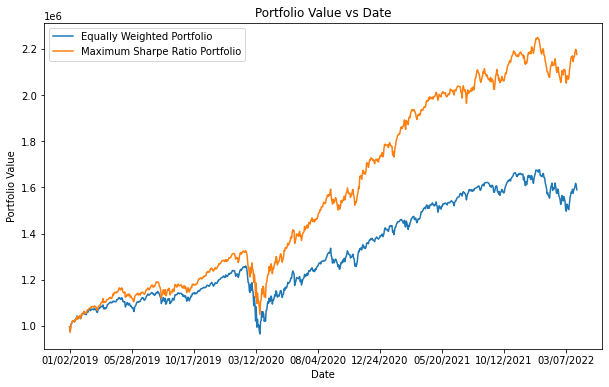

In [ ]:
default_strategy = np.reshape(portf_value[0], [1,-1])
client_strategy = np.reshape(portf_value[1], [1,-1])


df_1 =pd.DataFrame(default_strategy, columns = dates)
df_1 = df_1.append(pd.DataFrame(client_strategy, columns = dates), ignore_index=True)


df_1['methods'] =[strategy_names[0], strategy_names[1]]
df_1 = df_1.set_index('methods')
df_1.T.plot(figsize=(10,6),
        title='Portfolio Value vs Date',
        xlabel='Date',
        ylabel='Portfolio Value')
plt.legend()
plt.show()

In [ ]:
day_2022_start = np.where(dates_array[:,0]==2022)[0][0]
day_2022_end = np.where(dates_array[:,0]==2022)[0][-1]
returns_2022 = data_prices[day_2022_start+1:day_2022_end,:] / data_prices[day_2022_start:day_2022_end-1,:] - 1
mu_2022 = np.mean(returns_2022, axis = 0)
Q_2022 = np.cov(returns_2022.T)
data_prices_2022 = data_prices[day_2022_start:,:]
# # store 2022 data price
data_prices_2022 = data_prices[day_2022_start:,:]
dates_array_2022 = dates_array[day_2022_start:,:]
dates_2022 = dates[day_2022_start:]




In [ ]:
init_positions = np.zeros((1,len(preferred_etf)))
weight_portfolio = fh_array[1](init_positions, 0, mu_2022, Q_2022, data_prices_2022[-1], cash_pct, 1)[0]
print('The weights of each ETF in your portfolio will be:', weight_portfolio)

The weights of each ETF in your portfolio will be: [3653  880 1021  756 2035]
